In [1]:
%matplotlib inline

<div class="document" id="adaptive-thresholding">
<h1 class="title">Adaptive Thresholding</h1>
<p>Thresholding is the simplest way to segment objects from a background. If that
background is relatively uniform, then you can use a global threshold value to
binarize the image by pixel-intensity. If there's large variation in the
background intensity, however, adaptive thresholding (a.k.a. local or dynamic
thresholding) may produce better results.</p>
<p>Here, we binarize an image using the <cite>threshold_adaptive</cite> function, which
calculates thresholds in regions of size <cite>block_size</cite> surrounding each pixel
(i.e. local neighborhoods). Each threshold value is the weighted mean of the
local neighborhood minus an offset value.</p>
</div>


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import data
from skimage.filters import threshold_otsu, threshold_adaptive, gaussian_filter
from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.filters import sobel
from skimage.external.tifffile import TiffFile
from skimage import morphology
   
path = r'c:\Users\M1SRH\Documents\Projects\Customer_Projects\Rare_Event_LaserDissection_Michael Graf\GFP_Mutant_EDF\GFP_WT_EDF'
filename = r'\GFP_WT_EDF_s05_ORG.tif'

with TiffFile(path + filename) as tif:
    imagestack = tif.asarray()
    print imagestack.shape

tif.close()

(500L, 500L)


In [7]:
# choose plane
#plane = 0
#image = imagestack[plane, :, :]
image = imagestack

# smooth the image
image = gaussian_filter(image, sigma=3)
#elevation_map = sobel(image)
print image.shape
print image.max()
print image.min()

(500L, 500L)
0.0786843737032
0.00395563837784


In [8]:
global_thresh = threshold_otsu(image)
print global_thresh
binary_global = image > global_thresh

block_size = 200
binary_adaptive = threshold_adaptive(image, block_size, offset=image.min()*0.1)

0.0178213216902


In [9]:
markers = np.zeros_like(image)
markers[image < global_thresh] = 1
markers[image > global_thresh] = 2
#markers[image < 0.01] = 1
#markers[image > 0.1] = 2

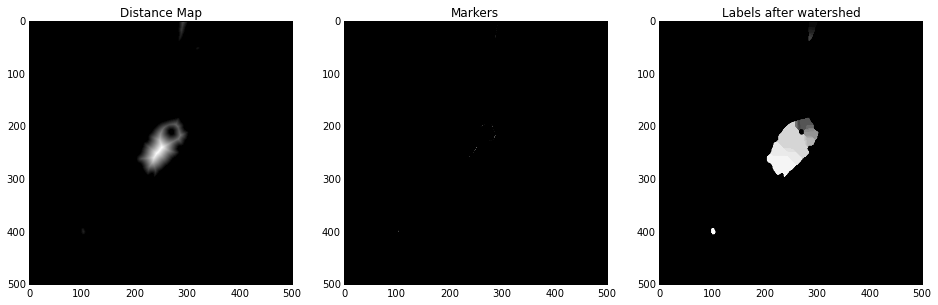

In [10]:
from skimage.feature import peak_local_max
from skimage.measure import label

distance = ndi.distance_transform_edt(binary_global)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=binary_global)
markers = label(local_maxi)
labels_ws = watershed(-distance, markers, mask=binary_global)

fig, axes = plt.subplots(ncols=3,  figsize=(16, 16))
ax0, ax1, ax2 = axes
plt.gray()

ax0.imshow(distance)
ax0.set_title('Distance Map')

ax1.imshow(markers)
ax1.set_title('Markers')

ax2.imshow(labels_ws)
ax2.set_title('Labels after watershed')


In [11]:
binary_global = watershed(image, markers)
#binary_adaptive = watershed(image, markers)
binary_global = ndi.binary_fill_holes(binary_global-1)
binary_adaptive = ndi.binary_fill_holes(binary_adaptive-1)

In [12]:
# remove small objects
binary_global_cleaned = morphology.remove_small_objects(binary_global, 100)
#label_objects, nb_labels = ndi.label(binary_global)
#sizes = np.bincount(label_objects.ravel())
#mask_sizes = sizes > 20
#mask_sizes[0] = 0
#cells_cleaned = mask_sizes[label_objects]

C:\Anaconda\lib\site-packages\skimage\morphology\misc.py:119: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warnings.warn("Only one label was provided to `remove_small_objects`. "


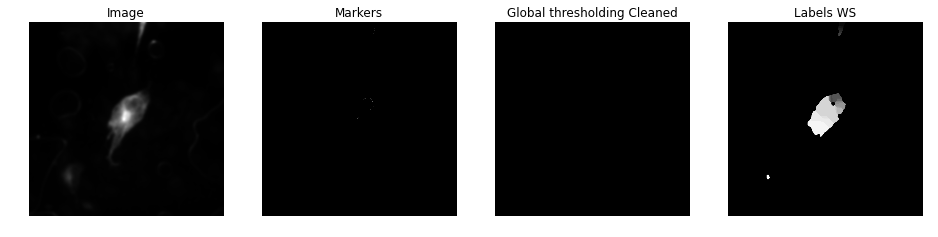

In [13]:
fig, axes = plt.subplots(ncols=4,  figsize=(16, 16))
ax0, ax1, ax2, ax3 = axes
plt.gray()

ax0.imshow(image)
ax0.set_title('Image')

ax1.imshow(markers)
ax1.set_title('Markers')

#ax2.imshow(binary_global)
#ax2.set_title('Global thresholding')

ax2.imshow(binary_global_cleaned)
ax2.set_title('Global thresholding Cleaned')

ax3.imshow(labels_ws)
ax3.set_title('Labels WS')

#ax3.imshow(binary_adaptive)
#ax3.set_title('Adaptive thresholding')

for ax in axes:
    ax.axis('off')

plt.show()